# RDKit Interface

RDKit is a cheminformatics toolkit that provides extensive functionality for molecular manipulation, analysis, and property calculation.

RDKit molecules contain **explicit bond information**.

For more information about RDKit, visit https://www.rdkit.org/docs/index.html

In [1]:
from IPython.display import display
from rdkit import Chem

import molify

## RDKit → ASE: connectivity key.

When we convert from RDKit to ASE, all the bond information is preserved in the ``atoms.info['connectivity']`` object and the initial charge state of the atoms object.
The following example creates an acetic acid molecule to demonstrate this conversion.

Acetic acid molecule:


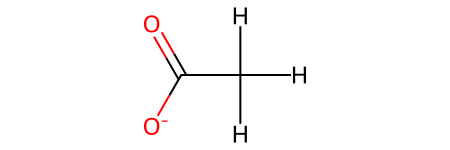

In [2]:
# Create acetic acid from SMILES
acetic_acid = Chem.MolFromSmiles("CC(=O)[O-]")
acetic_acid = Chem.AddHs(acetic_acid)  # Add explicit hydrogens

# Display the molecule
print("Acetic acid molecule:")
display(acetic_acid)

In [3]:
# Convert to ASE
acetic_acid_atoms = molify.rdkit2ase(acetic_acid)

print(f"Number of atoms: {len(acetic_acid_atoms)}")
print(f"Chemical formula: {acetic_acid_atoms.get_chemical_formula()}")
print(f"\nAtoms object: {acetic_acid_atoms}")
print(f"Initial charge: {acetic_acid_atoms.get_initial_charges()}")

Number of atoms: 7
Chemical formula: C2H3O2

Atoms object: Atoms(symbols='C2O2H3', pbc=False, initial_charges=...)
Initial charge: [ 0.  0.  0. -1.  0.  0.  0.]


### The `connectivity` Data Structure

The bond information is stored in `atoms.info['connectivity']` as a list of tuples:

```python
[(atom_idx_1, atom_idx_2, bond_order), ...]
```

Where:
- **atom_idx_1, atom_idx_2**: 0-based integer atom indices
- **bond_order**: Float representing bond type:
  - `1.0` = single bond
  - `2.0` = double bond  
  - `3.0` = triple bond
  - `1.5` = aromatic bond
  - `None` = unknown bond order

The following examines the connectivity:

In [4]:
# Display the connectivity information
connectivity = acetic_acid_atoms.info["connectivity"]
print("Connectivity structure:")
print(f"Total bonds: {len(connectivity)}\n")

for i, (atom1, atom2, bond_order) in enumerate(connectivity):
    symbol1 = acetic_acid_atoms.get_chemical_symbols()[atom1]
    symbol2 = acetic_acid_atoms.get_chemical_symbols()[atom2]
    print(
        f"  Bond {i}: atom {atom1} ({symbol1}) - atom {atom2} ({symbol2}), order = {bond_order}"
    )

Connectivity structure:
Total bonds: 6

  Bond 0: atom 0 (C) - atom 1 (C), order = 1.0
  Bond 1: atom 1 (C) - atom 2 (O), order = 2.0
  Bond 2: atom 1 (C) - atom 3 (O), order = 1.0
  Bond 3: atom 0 (C) - atom 4 (H), order = 1.0
  Bond 4: atom 0 (C) - atom 5 (H), order = 1.0
  Bond 5: atom 0 (C) - atom 6 (H), order = 1.0


In [5]:
# The SMILES string is also stored for convenience
print(f"Original SMILES: {acetic_acid_atoms.info['smiles']}")
print(f"\nAll info keys: {list(acetic_acid_atoms.info.keys())}")

Original SMILES: [H]C([H])([H])C(=O)[O-]

All info keys: ['smiles', 'connectivity']


### Key Insight

When converting from RDKit to ASE, **all bond information is explicit**:
- ✅ Bond connectivity is known
- ✅ Bond orders are known
- ✅ Formal charges are preserved
- ✅ SMILES string is stored

## RDKit → NetworkX: Understanding Graph Structure

NetworkX provides a graph-based representation that's useful for analyzing molecular topology, finding cycles, and understanding connectivity patterns.

The following converts the same acetic acid molecule to a NetworkX graph:

In [6]:
import networkx as nx

# Convert to NetworkX graph
acetic_acid_graph = molify.rdkit2networkx(acetic_acid)

print(f"Number of nodes (atoms): {acetic_acid_graph.number_of_nodes()}")
print(f"Number of edges (bonds): {acetic_acid_graph.number_of_edges()}")

Number of nodes (atoms): 7
Number of edges (bonds): 6


### Node Attributes: Atom Properties

Each node in the graph represents an atom with these attributes:
- `atomic_number`: Element atomic number (e.g., 6 for carbon, 8 for oxygen)
- `original_index`: Index from the RDKit molecule
- `charge`: Formal charge on the atom

The following examines a few nodes:

In [7]:
for node_id in list(acetic_acid_graph.nodes):
    attrs = acetic_acid_graph.nodes[node_id]
    atomic_num = attrs["atomic_number"]
    symbol = acetic_acid_graph.nodes[node_id]["atomic_number"]
    print(f"  Node {node_id}: {symbol} (Z={atomic_num}), charge={attrs['charge']}")

  Node 0: 6 (Z=6), charge=0
  Node 1: 6 (Z=6), charge=0
  Node 2: 8 (Z=8), charge=0
  Node 3: 8 (Z=8), charge=-1
  Node 4: 1 (Z=1), charge=0
  Node 5: 1 (Z=1), charge=0
  Node 6: 1 (Z=1), charge=0


### Edge Attributes: Bond Information

Each edge represents a bond with:
- `bond_order`: The bond type (1.0, 2.0, 3.0, or 1.5 for aromatic)

When converting from RDKit, `bond_order` is always present.

In [8]:
# Display edge attributes (bonds)
for i, (node1, node2, attrs) in enumerate(list(acetic_acid_graph.edges(data=True))):
    symbol1 = acetic_acid_graph.nodes[node1]["atomic_number"]
    symbol2 = acetic_acid_graph.nodes[node2]["atomic_number"]
    bond_order = attrs["bond_order"]
    print(
        f"  Edge {i}: (z={symbol1},id=({node1})) - (z={symbol2},id=({node2})), bond_order={bond_order}"
    )

  Edge 0: (z=6,id=(0)) - (z=6,id=(1)), bond_order=1
  Edge 1: (z=6,id=(0)) - (z=1,id=(4)), bond_order=1
  Edge 2: (z=6,id=(0)) - (z=1,id=(5)), bond_order=1
  Edge 3: (z=6,id=(0)) - (z=1,id=(6)), bond_order=1
  Edge 4: (z=6,id=(1)) - (z=8,id=(2)), bond_order=2
  Edge 5: (z=6,id=(1)) - (z=8,id=(3)), bond_order=1


### Using NetworkX for Molecular Analysis (WHY IS THIS HERE?)

The following creates a more interesting molecule - benzene - to demonstrate graph analysis:

Benzene molecule:


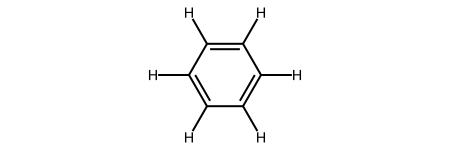


Nodes: 12, Edges: 12


In [9]:
# Create benzene
benzene_mol = Chem.MolFromSmiles("c1ccccc1")
benzene_mol = Chem.AddHs(benzene_mol)

print("Benzene molecule:")
display(benzene_mol)

# Convert to graph
benzene_graph = molify.rdkit2networkx(benzene_mol)
print(
    f"\nNodes: {benzene_graph.number_of_nodes()}, Edges: {benzene_graph.number_of_edges()}"
)

In [10]:
# Find all cycles in benzene
cycles = nx.cycle_basis(benzene_graph)
print(f"Number of cycles found: {len(cycles)}\n")

# The aromatic ring should be the largest cycle
aromatic_ring = max(cycles, key=len)
print(f"Aromatic ring (6-membered): {aromatic_ring}")

# Check bond orders in the aromatic ring
print("\nBond orders in the aromatic ring:")
for i in range(len(aromatic_ring)):
    node1 = aromatic_ring[i]
    node2 = aromatic_ring[(i + 1) % len(aromatic_ring)]
    if benzene_graph.has_edge(node1, node2):
        bond_order = benzene_graph[node1][node2]["bond_order"]
        print(f"  C{node1} - C{node2}: {bond_order} (aromatic)")

Number of cycles found: 1

Aromatic ring (6-membered): [4, 3, 2, 1, 0, 5]

Bond orders in the aromatic ring:
  C4 - C3: 1.5 (aromatic)
  C3 - C2: 1.5 (aromatic)
  C2 - C1: 1.5 (aromatic)
  C1 - C0: 1.5 (aromatic)
  C0 - C5: 1.5 (aromatic)
  C5 - C4: 1.5 (aromatic)


## Working with Complex Molecules

The following examines a more complex molecule with different bond types - aspirin:

Aspirin molecule:


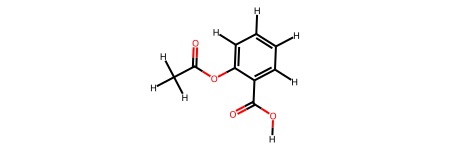


Atoms(symbols='C2O2C7O2H8', pbc=False)


In [11]:
# Create aspirin
aspirin_smiles = "CC(=O)Oc1ccccc1C(=O)O"
aspirin_mol = Chem.MolFromSmiles(aspirin_smiles)
aspirin_mol = Chem.AddHs(aspirin_mol)

print("Aspirin molecule:")
display(aspirin_mol)

# Convert to ASE
aspirin_atoms = molify.rdkit2ase(aspirin_mol)
print(f"\n{aspirin_atoms}")

In [12]:
# Analyze bond types in aspirin
from collections import Counter

connectivity = aspirin_atoms.info["connectivity"]
bond_orders = [bond_order for _, _, bond_order in connectivity]
bond_counts = Counter(bond_orders)

print("Bond type distribution in aspirin:")
for bond_order, count in sorted(bond_counts.items()):
    bond_type = {1.0: "single", 1.5: "aromatic", 2.0: "double", 3.0: "triple"}.get(
        bond_order, "unknown"
    )
    print(f"  {bond_type} bonds (order={bond_order}): {count}")

Bond type distribution in aspirin:
  single bonds (order=1.0): 13
  aromatic bonds (order=1.5): 6
  double bonds (order=2.0): 2


## Converting Back: ASE/NetworkX → RDKit

When we have explicit connectivity information (from RDKit originally), converting back is straightforward:

Original molecule:


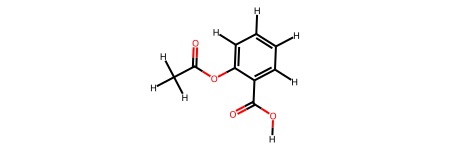


Round-trip molecule (ASE → RDKit):


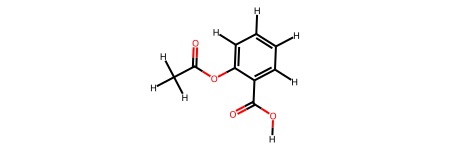

In [13]:
# ASE → RDKit (round-trip)
aspirin_roundtrip = molify.ase2rdkit(aspirin_atoms)

print("Original molecule:")
display(aspirin_mol)

print("\nRound-trip molecule (ASE → RDKit):")
display(aspirin_roundtrip)

## Key Takeaways

### What We Learned

1. **RDKit has explicit bond information**

2. **ASE stores connectivity** in `atoms.info['connectivity']` as:
   ```python
   [(atom_idx_1, atom_idx_2, bond_order), ...]
   ```

3. **NetworkX graphs** store:
   - Nodes: `atomic_number`, `original_index`, `charge`
   - Edges: `bond_order` (always present from RDKit)

4. **Conversions from RDKit are lossless** - all chemical information is preserved